In [1]:
# %load honest_net.py
import numpy as np
import pandas as pd

import seaborn as sns

# Apply the default theme
sns.set_theme()

df = pd.read_csv("../../data/honest_net.tsv", sep="\t")
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]


# C&P from https://stackoverflow.com/a/39513799
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad / np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g


def parse_array(s):
    try:
        return np.fromstring(s, dtype=float, sep="|")
    except TypeError:
        return np.array([float("nan")])


def expand(row):
    compute = parse_array(row.compute)
    weakest = np.argmin(compute)
    strongest = np.argmax(compute)
    d = {}

    def wsg(k, v):
        d[k + "_weakest"] = v[weakest]
        d[k + "_strongest"] = v[strongest]
        d[k + "_gini"] = gini(v)

    rcompute = compute / np.sum(compute)
    wsg("compute", rcompute)
    activations = parse_array(row.activations)
    assert np.sum(activations) == row.number_activations or row.error
    ractivations = activations / np.sum(activations)
    wsg("activations", ractivations)
    reward = parse_array(row.reward)
    rreward = reward / np.sum(reward)
    wsg("reward", rreward)
    efficiency = rreward / ractivations
    wsg("efficiency", efficiency)
    d["activations_compute_gini_delta"] = d["activations_gini"] - d["compute_gini"]
    d["reward_activations_gini_delta"] = d["reward_gini"] - d["activations_gini"]
    return d


df = df.join(df.apply(expand, axis=1, result_type="expand"))

## Incentive Schemes for Georges  Protocol

In [2]:
d = df.query('protocol in ["tailstormll", "tailstorm"]')

### Efficiency of the weakest miner

We pick the weakest miner by compute power and calculate its

efficiency = relative reward / relative activations

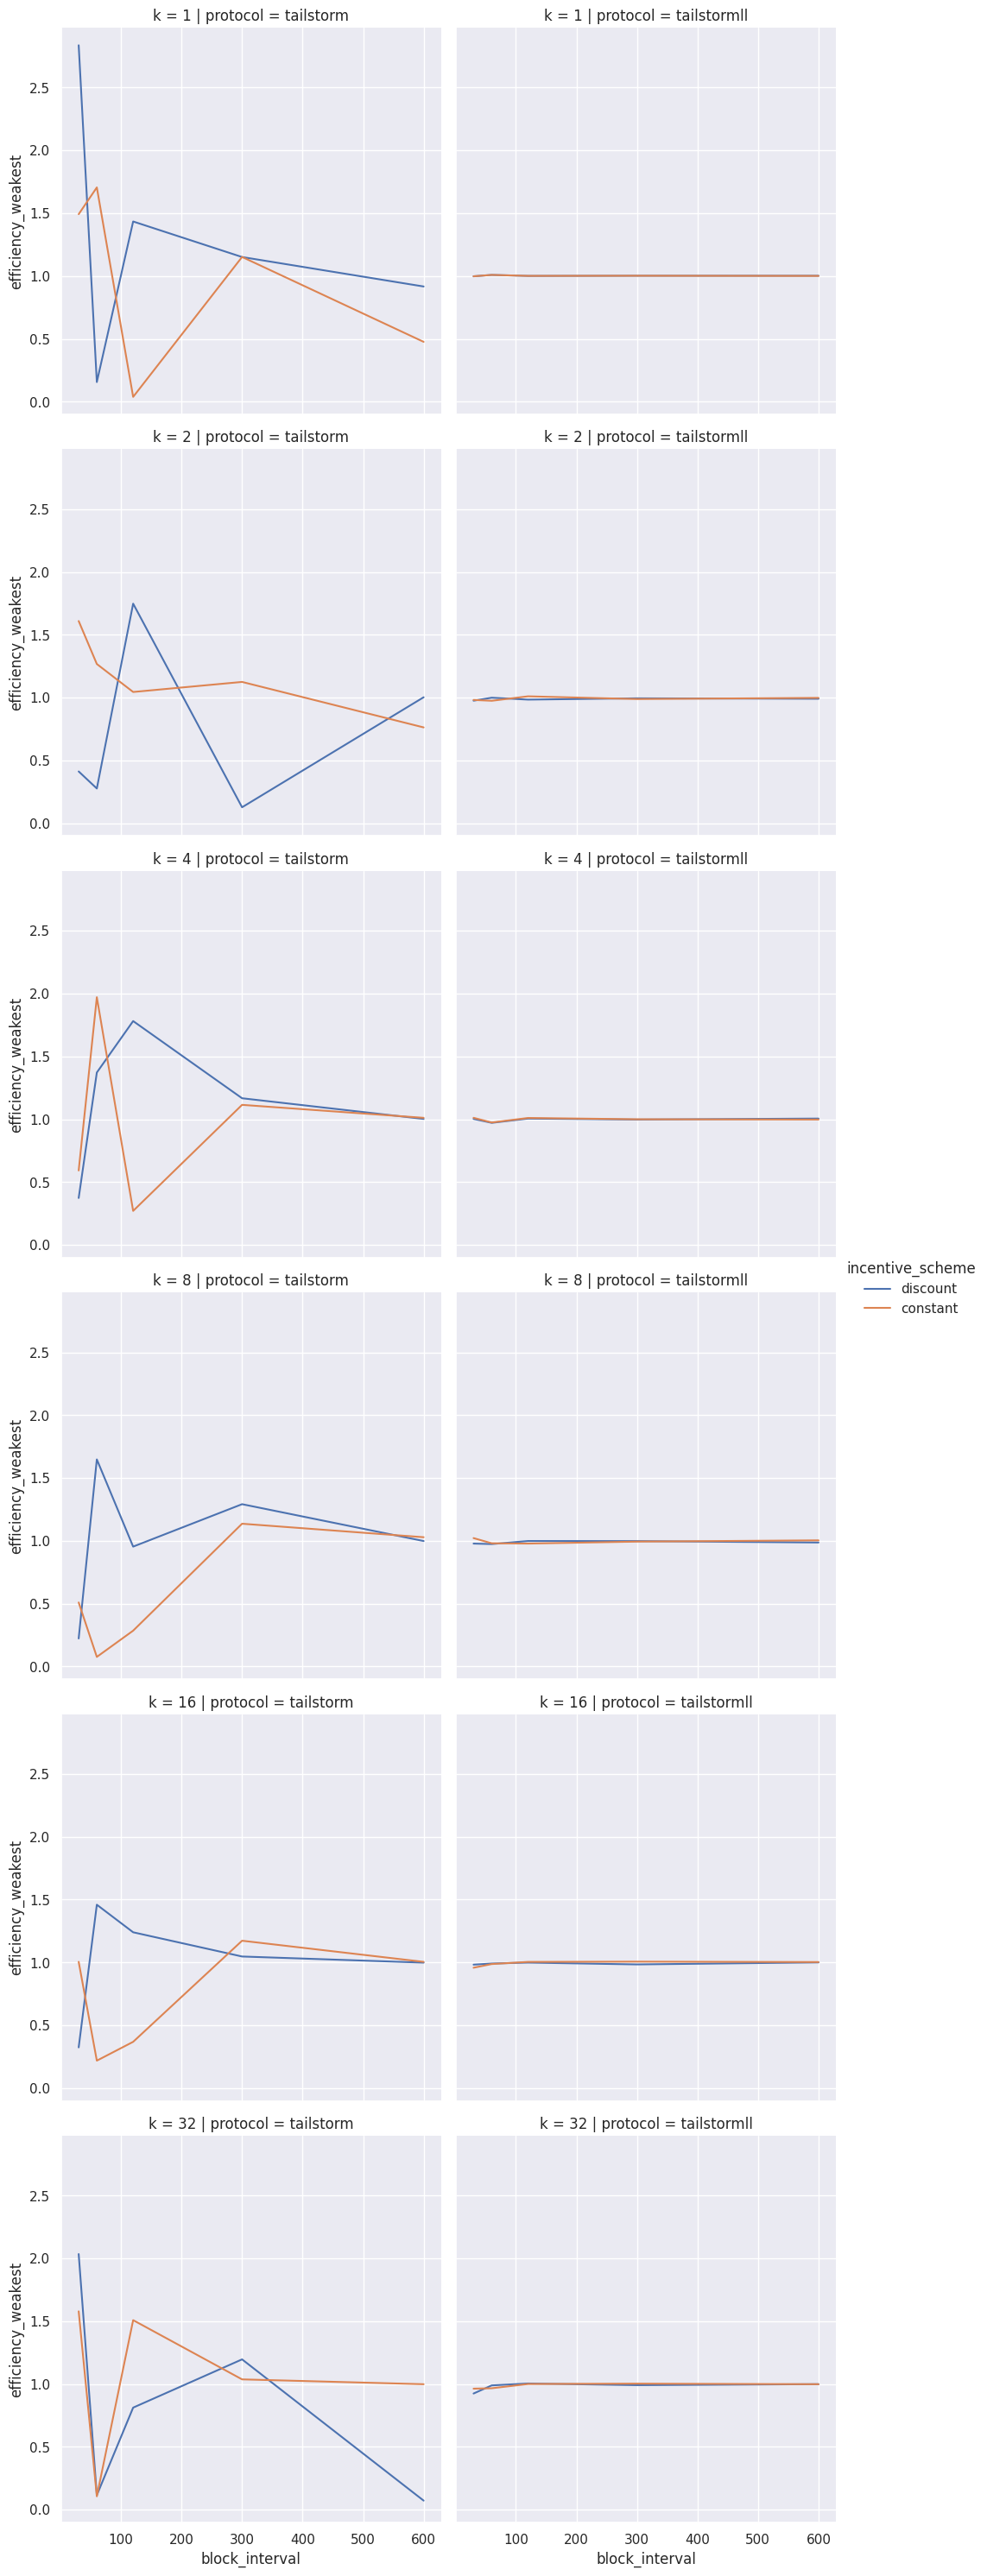

In [3]:
sns.relplot(
    data=d.query('incentive_scheme in ["constant", "discount"]'),
    x="block_interval",
    y="efficiency_weakest",
    col="protocol",
    row="k",
    hue="incentive_scheme",
    kind="line",
)

In [4]:
eff = d.rename(
    columns={"incentive_scheme": "Incentive Scheme", "block_interval": "Block Interval"}
).pivot(
    index=["Block Interval", "k", "protocol"],
    columns=["Incentive Scheme"],
    values="efficiency_weakest",
)
eff.style.to_latex(buf="../../tex/george-reward-inequality/tab/efficiency-weakest.tex")
eff

Incentive Scheme                  block  constant  discount    hybrid  \
Block Interval k  protocol                                              
30.0           1  tailstorm         NaN  1.492371  2.836742  0.013760   
                  tailstormll  1.005801  0.998077  0.998077  0.991009   
               2  tailstorm         NaN  1.609686  0.412621  1.774502   
                  tailstormll  0.970428  0.981775  0.975768  0.972310   
               4  tailstorm         NaN  0.592350  0.373270  0.000000   
                  tailstormll  0.974498  1.011477  1.002731  0.921448   
               8  tailstorm         NaN  0.509511  0.223040  2.091284   
                  tailstormll  1.152414  1.021965  0.978256  0.931627   
               16 tailstorm         NaN  1.004983  0.324123  0.417652   
                  tailstormll  0.820120  0.957945  0.982465  0.931978   
               32 tailstorm         NaN  1.578667  2.034643  1.018364   
                  tailstormll  0.760081  0.963338  0.924558  0.840914   
60.0           1  tailstorm         NaN  1.705328  0.156271  1.022875   
                  tailstormll  1.002298  1.009017  1.009017  0.987181   
               2  tailstorm         NaN  1.267766  0.276959  1.758272   
                  tailstormll  0.939334  0.975143  0.999547  0.986845   
               4  tailstorm         NaN  1.971253  1.371953  0.315322   
                  tailstormll  1.068174  0.974258  0.971504  0.999540   
               8  tailstorm         NaN  0.076369  1.648155  1.511141   
                  tailstormll  1.067754  0.980623  0.974450  0.920219   
               16 tailstorm         NaN  0.218470  1.459489  1.669861   
                  tailstormll  1.136170  0.987257  0.991514  0.983833   
               32 tailstorm         NaN  0.106569  0.115616  0.303589   
                  tailstormll  0.360692  0.966506  0.989280  0.884274   
120.0          1  tailstorm         NaN  0.038328  1.434304  0.412500   
                  tailstormll  1.006745  1.001392  1.001058  1.006745   
               2  tailstorm         NaN  1.045132  1.748089  1.508952   
                  tailstormll  0.966302  1.010523  0.984433  0.996991   
               4  tailstorm         NaN  0.270612  1.781321  0.973983   
                  tailstormll  0.896616  1.010239  1.005216  1.011829   
               8  tailstorm         NaN  0.285210  0.954096  0.037838   
                  tailstormll  0.733453  0.978374  0.998842  0.953507   
               16 tailstorm         NaN  0.368264  1.240113  0.206991   
                  tailstormll  0.368949  1.004443  0.998828  1.041081   
               32 tailstorm         NaN  1.508511  0.812411  1.487867   
                  tailstormll  0.676407  1.000365  1.004466  0.998378   
300.0          1  tailstorm         NaN  1.151941  1.151410  1.092299   
                  tailstormll  1.002406  1.002406  1.002305  1.002205   
               2  tailstorm         NaN  1.125113  0.127590  1.009695   
                  tailstormll  0.979314  0.988850  0.994716  0.996760   
               4  tailstorm         NaN  1.114576  1.167111  1.134802   
                  tailstormll  0.989762  0.999852  0.997550  1.006408   
               8  tailstorm         NaN  1.136364  1.291817  0.996630   
                  tailstormll  1.005632  0.994076  0.998108  0.975002   
               16 tailstorm         NaN  1.172939  1.047328  1.060123   
                  tailstormll  0.929316  1.006441  0.984311  0.990853   
               32 tailstorm         NaN  1.037225  1.196435  0.314989   
                  tailstormll  0.960061  1.003398  0.991290  1.007581   
600.0          1  tailstorm         NaN  0.476342  0.916885  1.001603   
                  tailstormll  1.001001  1.001001  1.002205  1.001101   
               2  tailstorm         NaN  0.763145  1.003110  0.756592   
                  tailstormll  1.045603  0.998345  0.991123  0.998299   
               4  tailstorm         NaN  1.011327  1.00252

### Reward Gini Fairness

We compare the rewards of all miners using the Gini coefficient. A lower coefficient implies more fairness. All numbers should be compared to the Gini coefficient of the compute powers.

In [5]:
d.compute_gini.unique()

array([0.3])

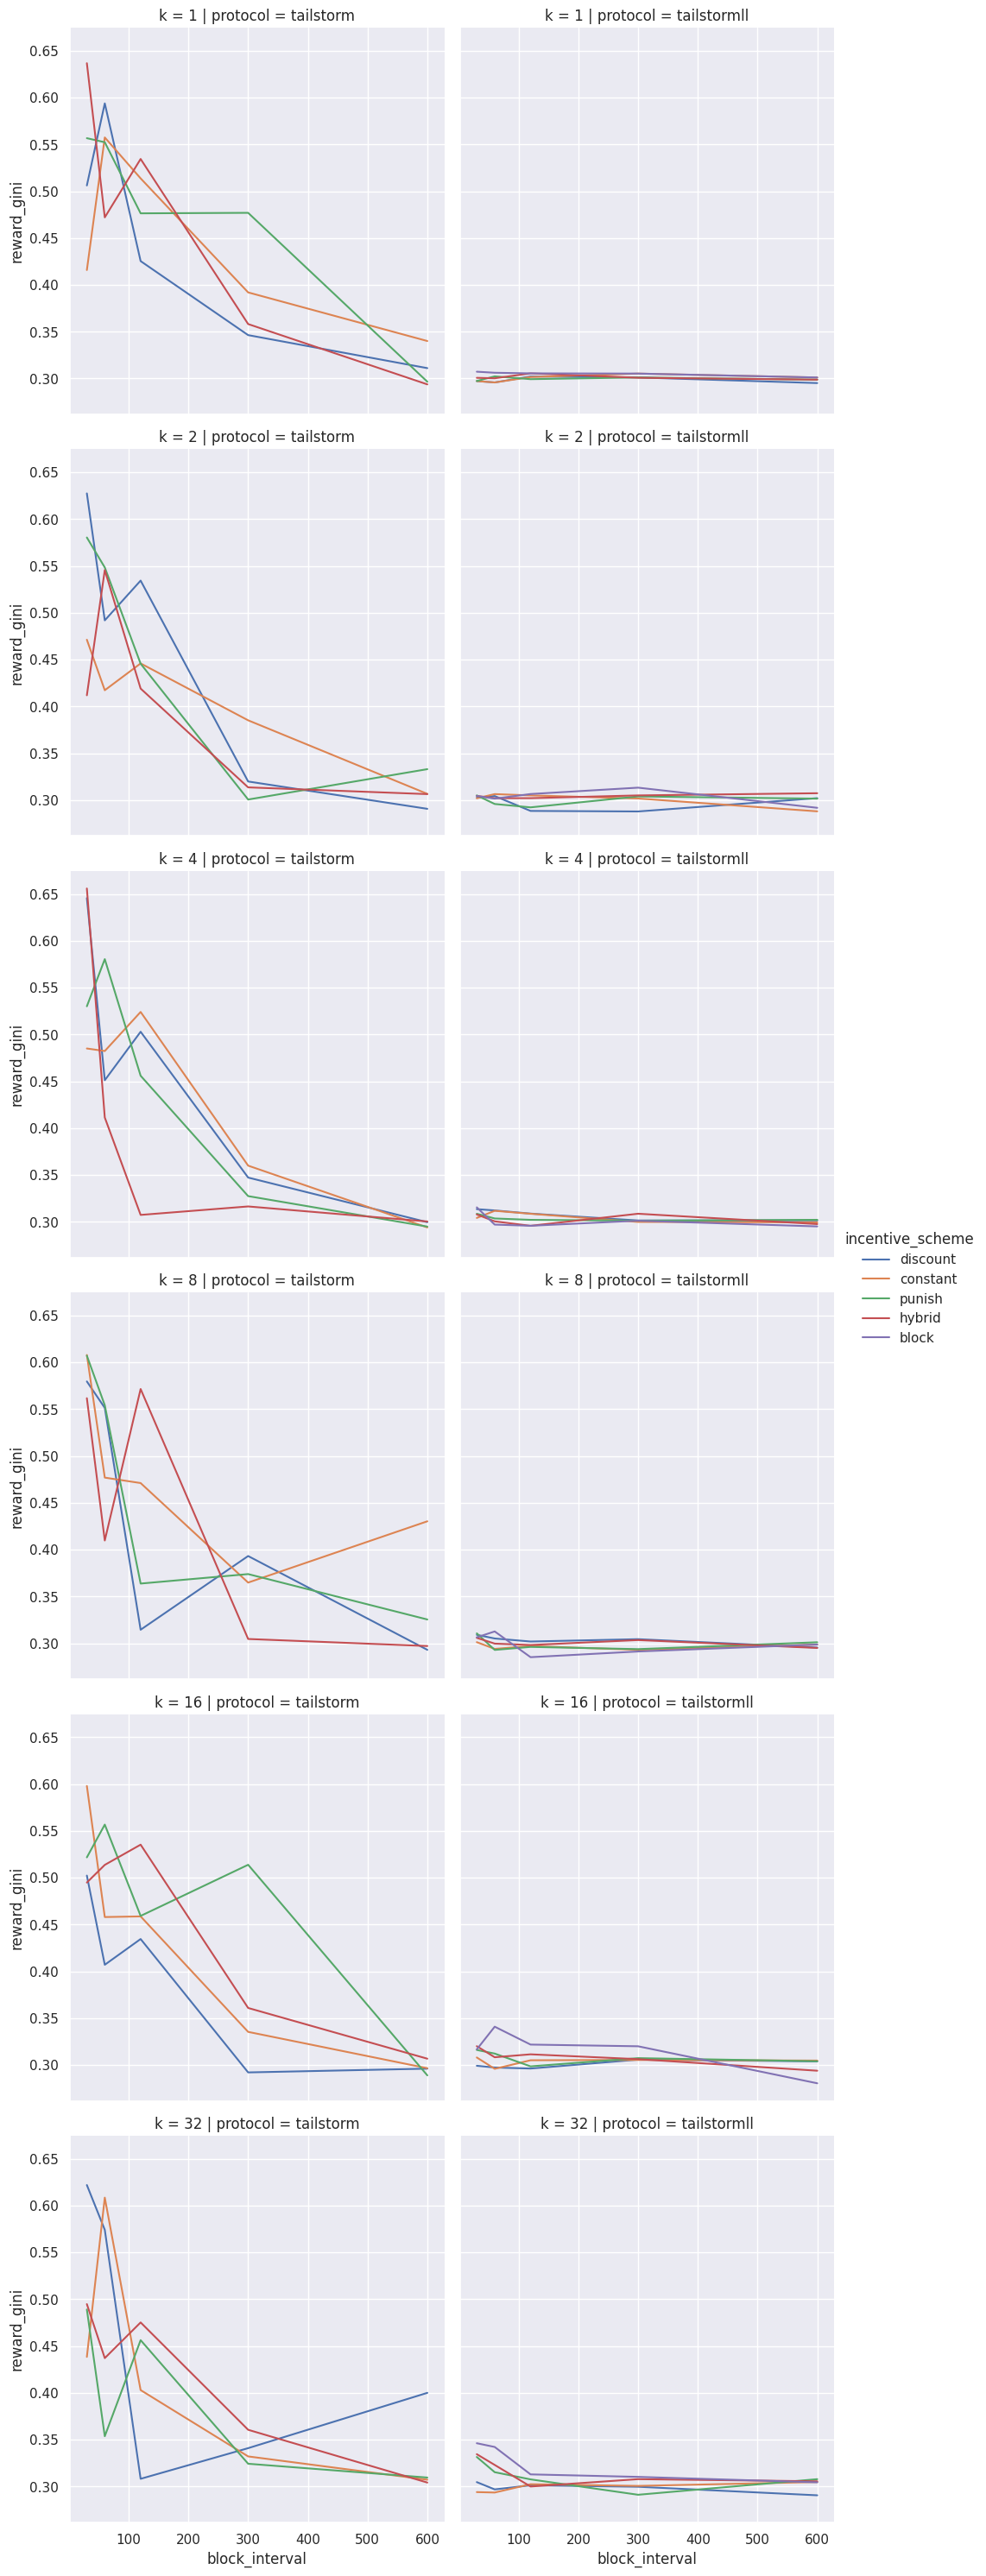

In [6]:
sns.relplot(
    data=d,
    x="block_interval",
    y="reward_gini",
    col="protocol",
    row="k",
    hue="incentive_scheme",
    kind="line",
)

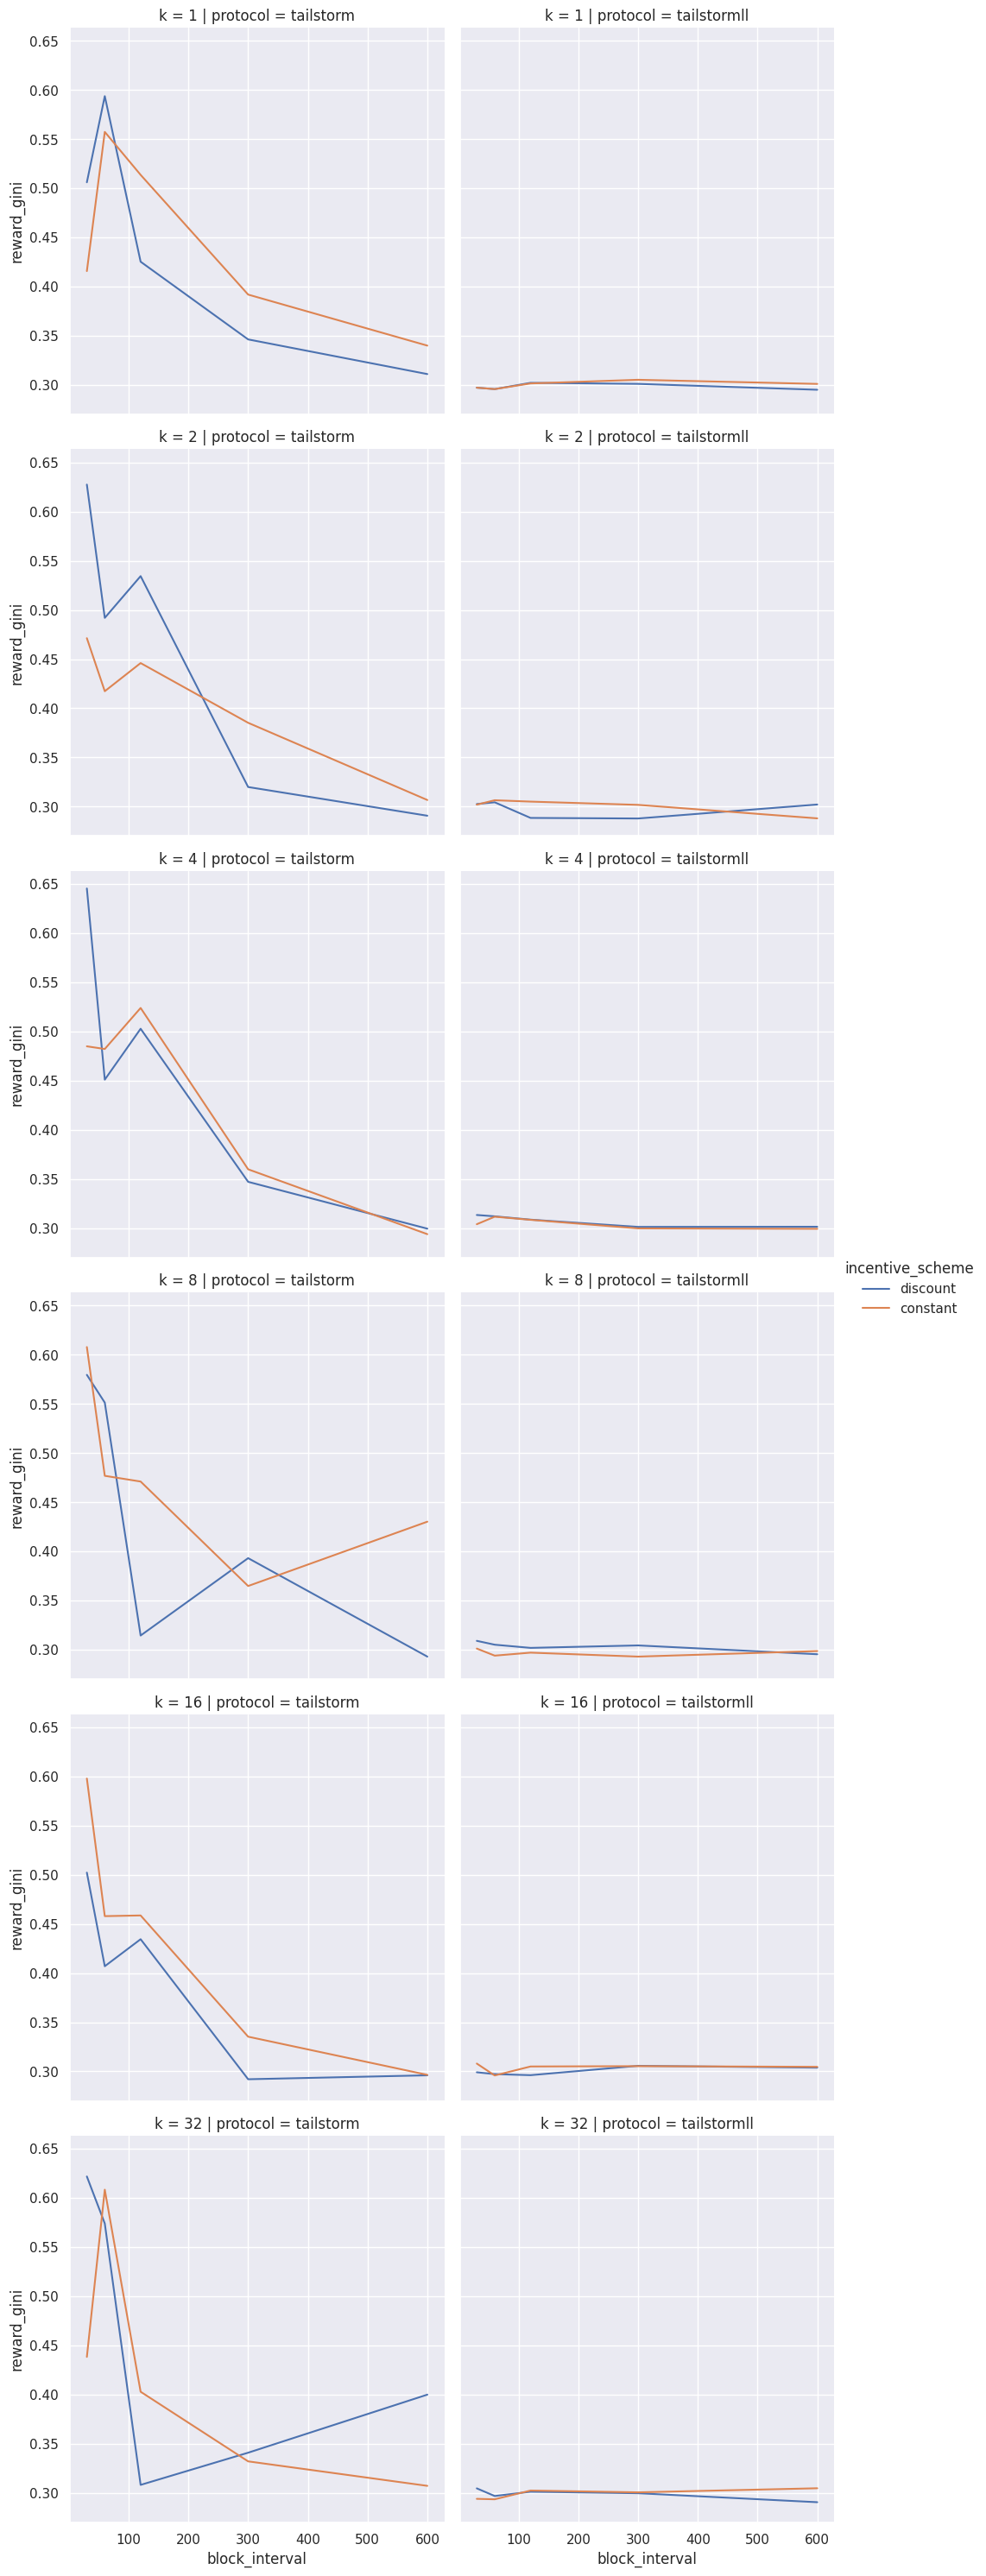

In [7]:
sns.relplot(
    data=d[
        (d["incentive_scheme"] == "constant") | (d["incentive_scheme"] == "discount")
    ],
    x="block_interval",
    y="reward_gini",
    col="protocol",
    row="k",
    hue="incentive_scheme",
    kind="line",
)

In [8]:
gini = d.rename(
    columns={"incentive_scheme": "Incentive Scheme", "block_interval": "Block Interval"}
).pivot(
    index=["Block Interval", "k", "protocol"],
    columns=["Incentive Scheme"],
    values="reward_gini",
)
gini.style.to_latex(buf="../../tex/george-reward-inequality/tab/reward-gini.tex")
gini

Incentive Scheme                  block  constant  discount    hybrid  \
Block Interval k  protocol                                              
30.0           1  tailstorm         NaN  0.415853  0.506166  0.636708   
                  tailstormll  0.307314  0.297288  0.297288  0.300762   
               2  tailstorm         NaN  0.471311  0.627539  0.411961   
                  tailstormll  0.304489  0.301986  0.302622  0.304502   
               4  tailstorm         NaN  0.484997  0.645544  0.655860   
                  tailstormll  0.315365  0.304053  0.313448  0.307779   
               8  tailstorm         NaN  0.607930  0.579654  0.561766   
                  tailstormll  0.306446  0.301272  0.309116  0.305862   
               16 tailstorm         NaN  0.597880  0.502204  0.494749   
                  tailstormll  0.316610  0.307972  0.299122  0.320045   
               32 tailstorm         NaN  0.438427  0.621944  0.494796   
                  tailstormll  0.346259  0.294070  0.304733  0.334543   
60.0           1  tailstorm         NaN  0.557422  0.593807  0.472095   
                  tailstormll  0.306187  0.295839  0.295839  0.300304   
               2  tailstorm         NaN  0.417362  0.491967  0.545667   
                  tailstormll  0.301606  0.306466  0.304386  0.302122   
               4  tailstorm         NaN  0.482279  0.451101  0.411285   
                  tailstormll  0.296953  0.311682  0.312090  0.300415   
               8  tailstorm         NaN  0.476962  0.551412  0.409803   
                  tailstormll  0.312706  0.294069  0.305190  0.299706   
               16 tailstorm         NaN  0.457914  0.406968  0.513609   
                  tailstormll  0.340857  0.295861  0.297235  0.308219   
               32 tailstorm         NaN  0.608482  0.574117  0.437133   
                  tailstormll  0.342244  0.293606  0.296945  0.323070   
120.0          1  tailstorm         NaN  0.513731  0.425399  0.534442   
                  tailstormll  0.305537  0.301591  0.302216  0.305537   
               2  tailstorm         NaN  0.445988  0.534414  0.419138   
                  tailstormll  0.306538  0.305082  0.288492  0.302112   
               4  tailstorm         NaN  0.524014  0.502861  0.307297   
                  tailstormll  0.295702  0.308520  0.308706  0.295666   
               8  tailstorm         NaN  0.471144  0.314524  0.571552   
                  tailstormll  0.285227  0.297119  0.301950  0.298234   
               16 tailstorm         NaN  0.458613  0.434445  0.535213   
                  tailstormll  0.321753  0.305000  0.296172  0.311350   
               32 tailstorm         NaN  0.402988  0.308253  0.475224   
                  tailstormll  0.312987  0.302504  0.301311  0.300026   
300.0          1  tailstorm         NaN  0.391971  0.346379  0.358176   
                  tailstormll  0.305313  0.305313  0.301163  0.300822   
               2  tailstorm         NaN  0.385239  0.319914  0.313647   
                  tailstormll  0.313339  0.301772  0.287918  0.305056   
               4  tailstorm         NaN  0.359910  0.347166  0.316345   
                  tailstormll  0.301126  0.299819  0.301341  0.308555   
               8  tailstorm         NaN  0.364886  0.393228  0.304665   
                  tailstormll  0.291311  0.293087  0.304454  0.303510   
               16 tailstorm         NaN  0.335307  0.292030  0.360839   
                  tailstormll  0.319936  0.305334  0.305686  0.306197   
               32 tailstorm         NaN  0.332177  0.340989  0.360601   
                  tailstormll  0.310323  0.300685  0.299770  0.307893   
600.0          1  tailstorm         NaN  0.340063  0.311113  0.293770   
                  tailstormll  0.301141  0.301121  0.295169  0.298819   
               2  tailstorm         NaN  0.306713  0.290731  0.306441   
                  tailstormll  0.291807  0.288050  0.302127  0.307388   
               4  tailstorm         NaN  0.293932  0.29953